### 1. Inital Env

Notes: `Rtools` is required to be installed to use `Rcpp` package. Here is an instruction for installing "[Rtools42 for Windows](https://cran.r-project.org/bin/windows/Rtools/rtools42/rtools.html)".

In [4]:
rm(list = ls())

#install.packages("Rcpp")
library(data.table)
library(ggplot2)
library(dtw)
library(Rcpp)
sourceCpp("shapeDTW_translate/dpcore.cpp")
sourceCpp("shapeDTW_translate/dpcore_window.cpp")
source("dist2.R")
source("dpfast.R")
source("WeightFunc.R")

### 2. Load Data

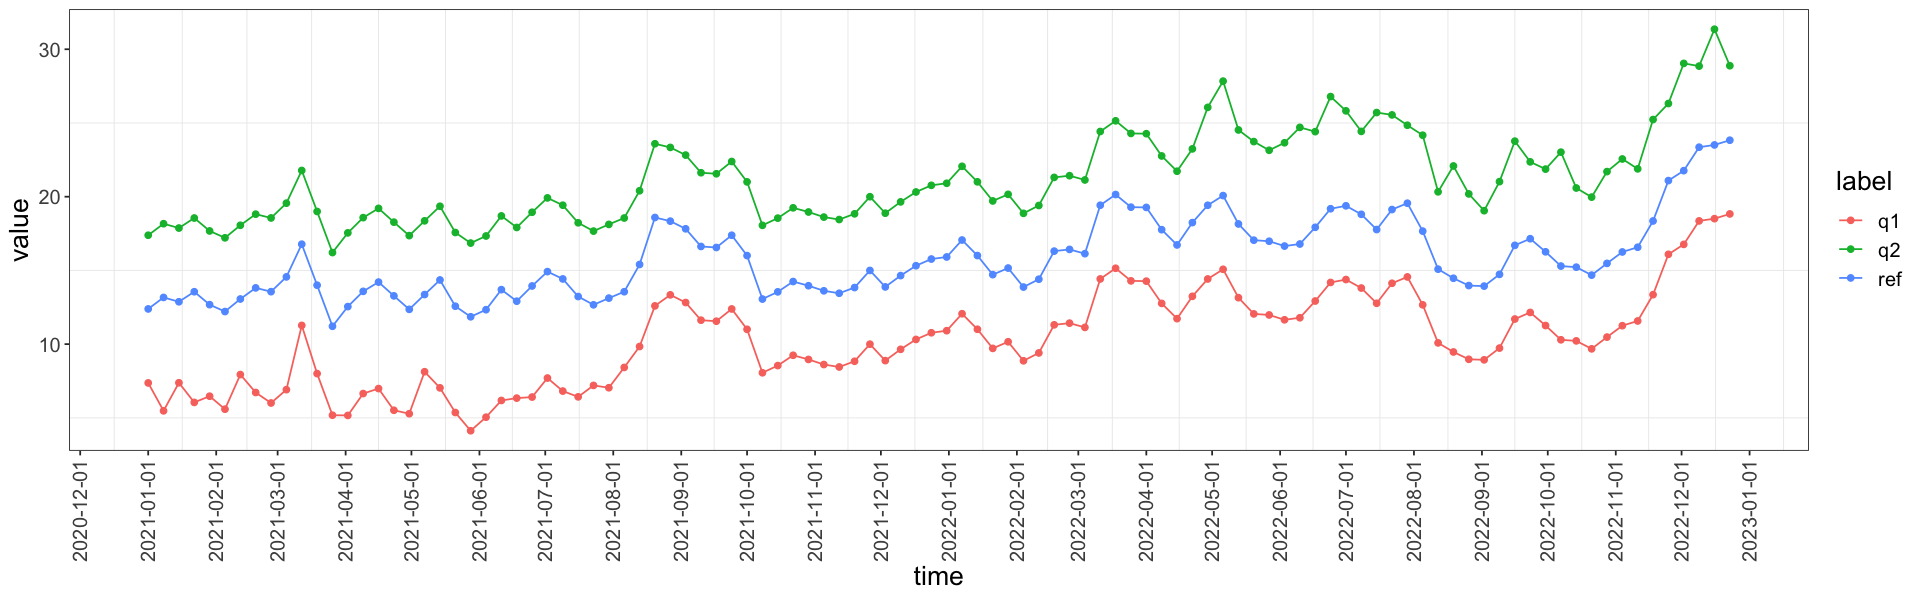

In [5]:
dt <- fread("data/testdata.csv")

options(repr.plot.width = 16, repr.plot.height = 5)
ggplot(data = dt, aes(x = time, y = value, color = label)) + 
  geom_point() + 
  geom_line() + 
  scale_x_date(breaks = "1 month") + 
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
    axis.title = element_text(size = 16), axis.text = element_text(size = 12), 
    legend.title = element_text(size = 16), legend.text = element_text(size = 12),
    plot.background = element_blank(),
    panel.grid.major = element_blank()
  )

In [6]:
seq_ref <- as.matrix(dt[label == "ref"]$value)
seq_q1 <- as.matrix(dt[label == "q1"]$value)
seq_q2 <- as.matrix(dt[label == "q2"]$value)
cat(paste0("Dimension of Reference Sequence: ", paste(dim(seq_ref), collapse = " x "),
           "\nDimension of 1st Query Sequence: ", paste(dim(seq_q1), collapse = " x "),
           "\nDimension of 2nd Query Sequence: ", paste(dim(seq_q2), collapse = " x ")))

Dimension of Reference Sequence: 104 x 1
Dimension of 1st Query Sequence: 104 x 1
Dimension of 2nd Query Sequence: 104 x 1

### 3. Calculate Distance, Path and Costs

In [5]:
# Regular distance matrix
M_1 <- dist2(x = seq_ref, c = seq_q1)
M_2 <- dist2(x = seq_ref, c = seq_q2)

# Weighted distance matrix
M_1_wdtw <- dist2(x = seq_ref, c = seq_q1, wt_func = weight_fcn)
M_2_wdtw <- dist2(x = seq_ref, c = seq_q2, wt_func = weight_fcn)

# Time-dependent Weighted distance matrix
M_1_tdwdtw <- dist2(x = seq_ref, c = seq_q1, wt_func = weight_fcn_prod)
M_2_tdwdtw <- dist2(x = seq_ref, c = seq_q2, wt_func = weight_fcn_prod)

# Define steppattern: symmetric2 in R built-in dtw package [1 1 2.0;0 1 1.0;1 0 1.0]
steppattern <- matrix(c(1, 1, 2.0, 0, 1, 1.0, 1, 0, 1.0), ncol = 3, byrow = TRUE)
dtw_methods = c("R built-in DTW", "dpfast DTW", "WDTW", "TD-WDTW")

In [6]:
# DTW package
pair_1_dtw <- dtw(x = seq_ref, y = seq_q1, keep = TRUE)
pair_2_dtw <- dtw(x = seq_ref, y = seq_q2, keep = TRUE)

# DTW from dpfast
pair_1 <- dpfast(M_1, C = steppattern)
pair_2 <- dpfast(M_2, C = steppattern)

# WDTW
pair_1_wdtw <- dpfast(M_1_wdtw, C = steppattern)
pair_2_wdtw <- dpfast(M_2_wdtw, C = steppattern)

# TD-WDTW
pair_1_tdwdtw <- dpfast(M_1_tdwdtw, C = steppattern)
pair_2_tdwdtw <- dpfast(M_2_tdwdtw, C = steppattern)

####  3.1 Mininum Global Distance Comparison

In [7]:
dist_comparison <- data.frame(matrix(NA, nrow = 4, ncol = 3))
colnames(dist_comparison) = c("algorithm", "query.1", "query.2")
dist_comparison$algorithm = dtw_methods
dist_comparison$query.1 = c(pair_1_dtw$distance, sum(pair_1$sc), sum(pair_1_wdtw$sc), sum(pair_1_tdwdtw$sc))
dist_comparison$query.2 = c(pair_2_dtw$distance, sum(pair_2$sc), sum(pair_2_wdtw$sc), sum(pair_2_tdwdtw$sc))
dist_comparison


algorithm,query.1,query.2
<chr>,<dbl>,<dbl>
R built-in DTW,389.614201,342.515384
dpfast DTW,389.614201,342.515384
WDTW,4.694959,4.579687
TD-WDTW,28.759093,29.719710


#### 3.2 Paths Plot

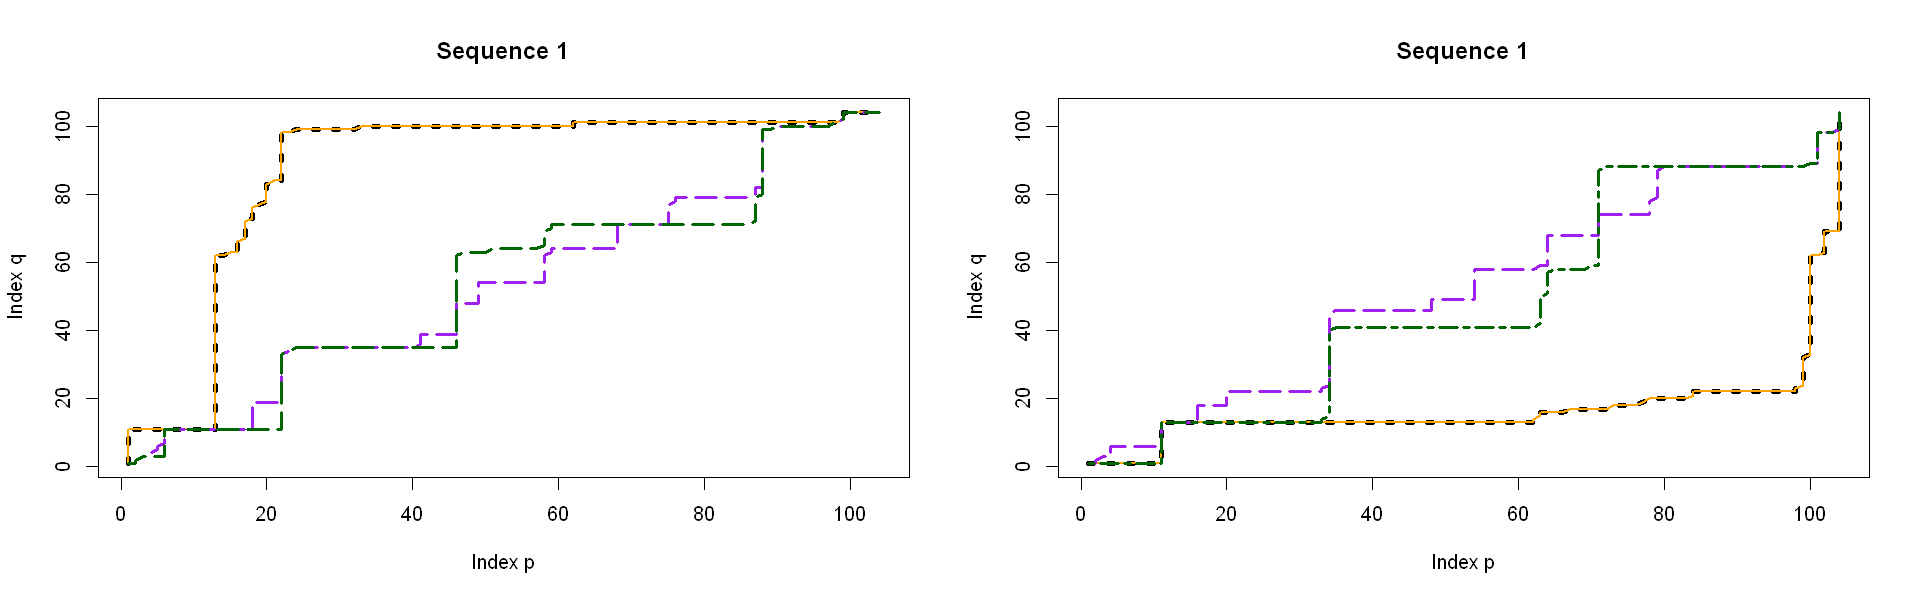

In [8]:
par(mfrow = c(1,2)) 
options(repr.plot.width = 16, repr.plot.height = 5)

# 1st query
plot(pair_1_dtw$index1, pair_1_dtw$index2, type = "l", lty = "dotted", lwd = 4,
     xlab = "Index p", ylab = "Index q", main = "Sequence 1")
lines(pair_1$p, pair_1$q, col = 'orange', lwd = 2)
lines(pair_1_wdtw$p, pair_1_wdtw$q, col = "purple", lty = "longdash", lwd = 3)
lines(pair_1_tdwdtw$p, pair_1_tdwdtw$q, col = "darkgreen", lty = "longdash", lwd = 3)

# 2nd query
plot(pair_2_dtw$index1, pair_2_dtw$index2, type = "l", lty = "dotted", lwd = 4,
     xlab = "Index p", ylab = "Index q", main = "Sequence 1")
lines(pair_2$p, pair_2$q, col = "orange", lwd = 2)
lines(pair_2_wdtw$p, pair_2_wdtw$q, col = "purple", lty = "longdash", lwd = 3)
lines(pair_2_tdwdtw$p, pair_2_tdwdtw$q, col = "darkgreen", lty = "twodash", lwd = 3)

In [9]:
idx_matched_dtw <- cbind(pair_1_dtw$index1, pair_1_dtw$index2)
idx_matched <- cbind(pair_1$p, pair_1$q)
idx_matched_wdtw <- cbind(pair_1_wdtw$p, pair_1_wdtw$q)
idx_matched_tdwdtw <- cbind(pair_1_tdwdtw$p, pair_1_tdwdtw$q)
dim(idx_matched)
dim(idx_matched_dtw)
dim(idx_matched_wdtw)
dim(idx_matched_tdwdtw)

[1] 198   2

[1] 198   2

[1] 195   2

[1] 195   2

In [10]:
# Compare the paths
path_d1 <- sum(pair_1_dtw$index1 != pair_1$p) + sum(pair_1_dtw$index2 != pair_1$q) # DTW Package vs. DTW from dpfast
path_d2 <- sum(pair_1_tdwdtw$p != pair_1_wdtw$p) + sum(pair_1_tdwdtw$q != pair_1_wdtw$q) # TD-WDTW vs. WDTW
path_comparison <- data.frame(matrix(NA, nrow = 2, ncol = 2))
colnames(path_comparison) <- c("pairs", "count.path.diff")
path_comparison[, 1] <- c("R built-in DTW vs. dpfast DTW", "WDTW vs. TD-WDTW")
path_comparison[, 2] <- c(path_d1, path_d2)
path_comparison

pairs,count.path.diff
<chr>,<int>
R built-in DTW vs. dpfast DTW,0
WDTW vs. TD-WDTW,225


In [11]:
# Normalize the distance
#time_wt_1 <- sapply(pair_1_wdtw$p, function(x) weight_fcn(x[1], 0, m=length(seq_ref), type='absolute'))
#time_wt_2 <- sapply(pair_2_wdtw$p, function(x) weight_fcn(x[1], 0, m=length(seq_ref), type='absolute'))
#print(sum(time_wt_1 * pair_1_wdtw$sc)/sum(time_wt_1))
#print(sum(time_wt_2 * pair_2_wdtw$sc)/sum(time_wt_2))

#### 3.3 Toy Example

[1] 1.470676
[1] 1.470676
[1] 0.1675151
[1] 0.3528513


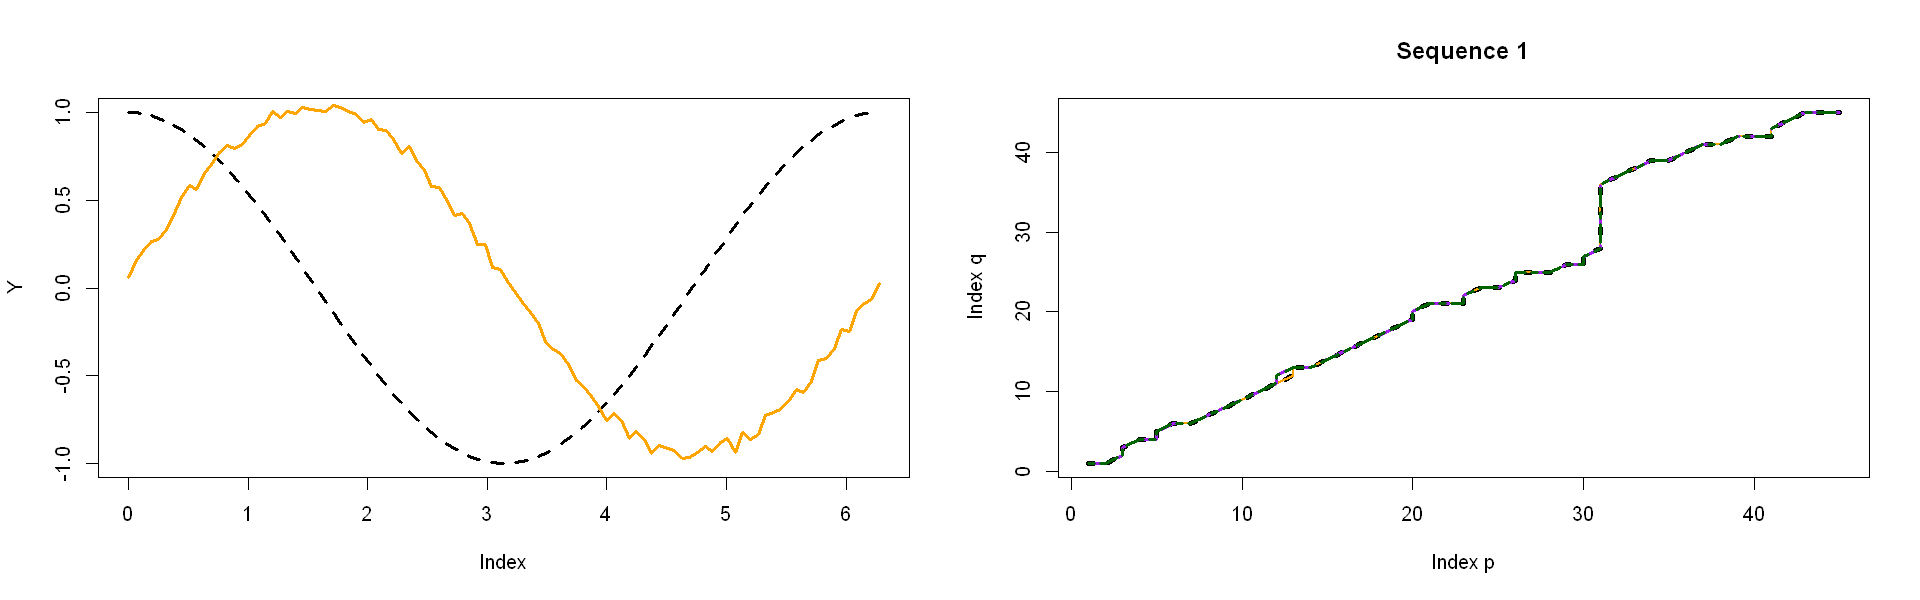

In [12]:
# Simulate data
set.seed(20230525)
idx <- seq(0, 6.28, len = 100)
query <- sin(idx) + runif(100)/10 
reference <- cos(idx) # Cosine is the reference; sin and cos are offset by 25 samples

# Compute distance matrix
M_test <- dist2(x = as.matrix(query[44:88]), c = as.matrix(reference[19:63]))
M_test_wdtw <- dist2(x = as.matrix(query[44:88]), c = as.matrix(reference[19:63]), wt_func = weight_fcn)
M_test_tdwdtw <- dist2(x = as.matrix(query[44:88]), c = as.matrix(reference[19:63]), wt_func = weight_fcn_prod)

# Compute path and minimal cost
pair_test_dtw <- dtw(query[44:88], reference[19:63], keep = TRUE, step = symmetric2) # symmetric2 in dtw package [1 1 2.0;0 1 1.0;1 0 1.0]
pair_test <- dpfast(M_test, C = steppattern)
pair_test_wdtw <- dpfast(M_test_wdtw, C = steppattern)
pair_test_tdwdtw <- dpfast(M_test_tdwdtw, C = steppattern)

# Print out the minimum cost
print(pair_test_dtw$distance)
print(sum(pair_test$sc))
print(sum(pair_test_wdtw$sc))
print(sum(pair_test_tdwdtw$sc))

# Plot original simulations
par(mfrow = c(1,2)) 
options(repr.plot.width = 16, repr.plot.height = 5)
plot(idx, reference, type = "l", lty = 2, lwd = 3, xlab = "Index", ylab = "Y")
lines(idx, query, col = "orange", lwd = 3)

# Plot optimal paths
plot(pair_test_dtw$index1, pair_test_dtw$index2, type = "l", lty = "dotted", lwd = 4,
     xlab = "Index p", ylab = "Index q", main = "Sequence 1")
lines(pair_test$p, pair_test$q, col = 'orange', lwd = 2)
lines(pair_test_wdtw$p, pair_test_wdtw$q, col = 'purple', lty = 'longdash', lwd = 3)
lines(pair_test_tdwdtw$p, pair_test_tdwdtw$q, col = 'darkgreen', lty = 'twodash', lwd = 3)

In [13]:
# Compare the paths
path_d1 <- sum(pair_test_dtw$index1 != pair_test$p) + sum(pair_test_dtw$index2 != pair_test$q) # DTW Package vs. DTW from dpfast
path_d2 <- sum(pair_test_wdtw$p != pair_test$p) + sum(pair_test_wdtw$q != pair_test$q) # WDTW vs DTW
path_d3 <- sum(pair_test_tdwdtw$p != pair_test$p) + sum(pair_test_tdwdtw$q != pair_test$q) # TD-WDTW vs DTW
path_d4 <- sum(pair_test_tdwdtw$p != pair_test_wdtw$p) + sum(pair_test_tdwdtw$q != pair_test_wdtw$q) # TD-WDTW vs WDTW
path_comparison <- data.frame(matrix(NA, nrow = 4, ncol = 2))
colnames(path_comparison) <- c("pairs", "count.path.diff")
path_comparison[, 1] <- c("R built-in DTW vs. dpfast DTW", "WDTW vs. DTW", "TD-WDTW vs. DTW", "WDTW vs. TD-WDTW")
path_comparison[, 2] <- c(path_d1, path_d2, path_d3, path_d4)
path_comparison

pairs,count.path.diff
<chr>,<int>
R built-in DTW vs. dpfast DTW,0
WDTW vs. DTW,1
TD-WDTW vs. DTW,1
WDTW vs. TD-WDTW,0


### 4. Plot Matching Results

https://statisticsglobe.com/add-line-segment-curve-ggplot2-plot-r

In [14]:
plot_matching <- function(xts, yts, pair_obj, methods, offset = 1, plt.width = 16, plt.height = 4.5) {

    options(repr.plot.width = plt.width, repr.plot.height = plt.height)
    # Save default for resetting
    #def.par <- par(no.readonly = TRUE)
    
    # Make room for secondary axis, if any
    if(offset != 0) {
        par(mar = c(4,4,2,4) + .1)
    }
    
    ytso <- yts + offset
    matplot(cbind(xts, ytso), type = "l", pch = 21, lwd = 3, 
            main = paste("Matching from", methods), xlab = "Index", ylab = "Query value")
    box()
    axis(1)
    axis(2, at = pretty(xts))
    
    # Display secondary axis if offset
    if(offset != 0) {
        rightTicks <- pretty(yts)
        axis(4, at = rightTicks + offset, labels = rightTicks)
    }

    ml <- length(pair_obj$p)
    idx <- 1:ml
    
    # x0, y0 coordinates of points from which to draw
    # x1, y1 coordinates of points to which to draw
    segments(pair_obj$p[idx], xts[pair_obj$p[idx]],  # from
             pair_obj$q[idx], ytso[pair_obj$q[idx]], # to
             col = "grey70", lty = "dotted")
    
    # Reset to default
    #par(def.par)
}

#### 4.1 Plot Simulation Data

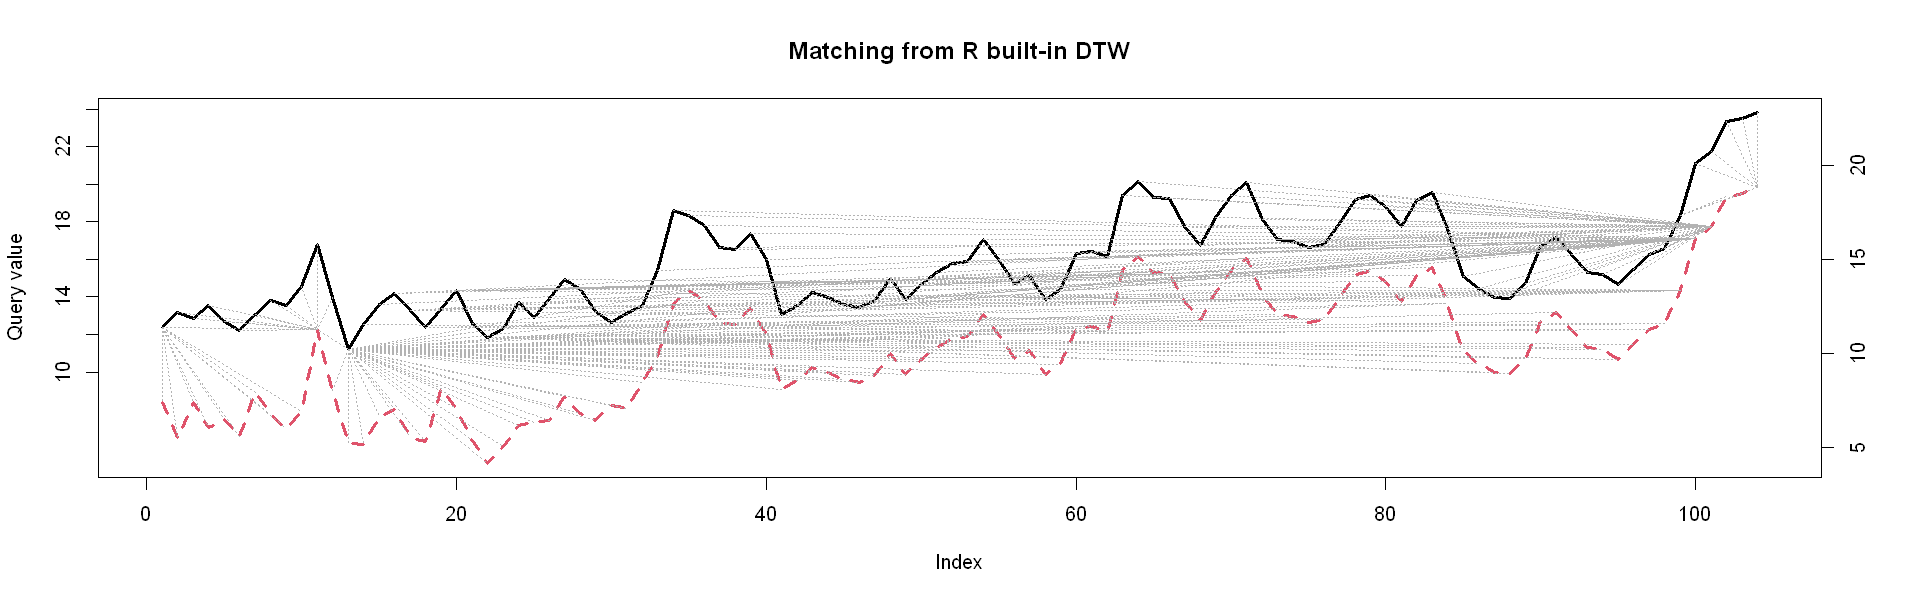

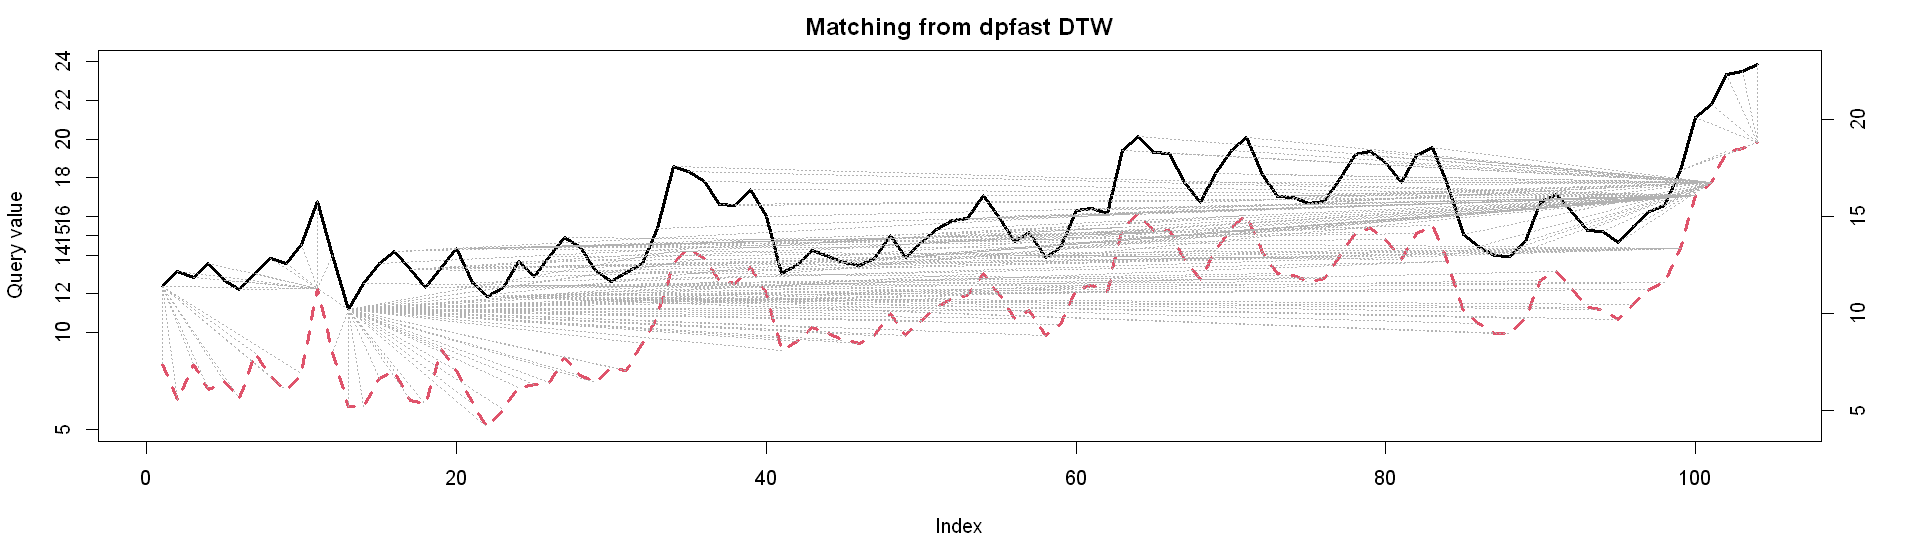

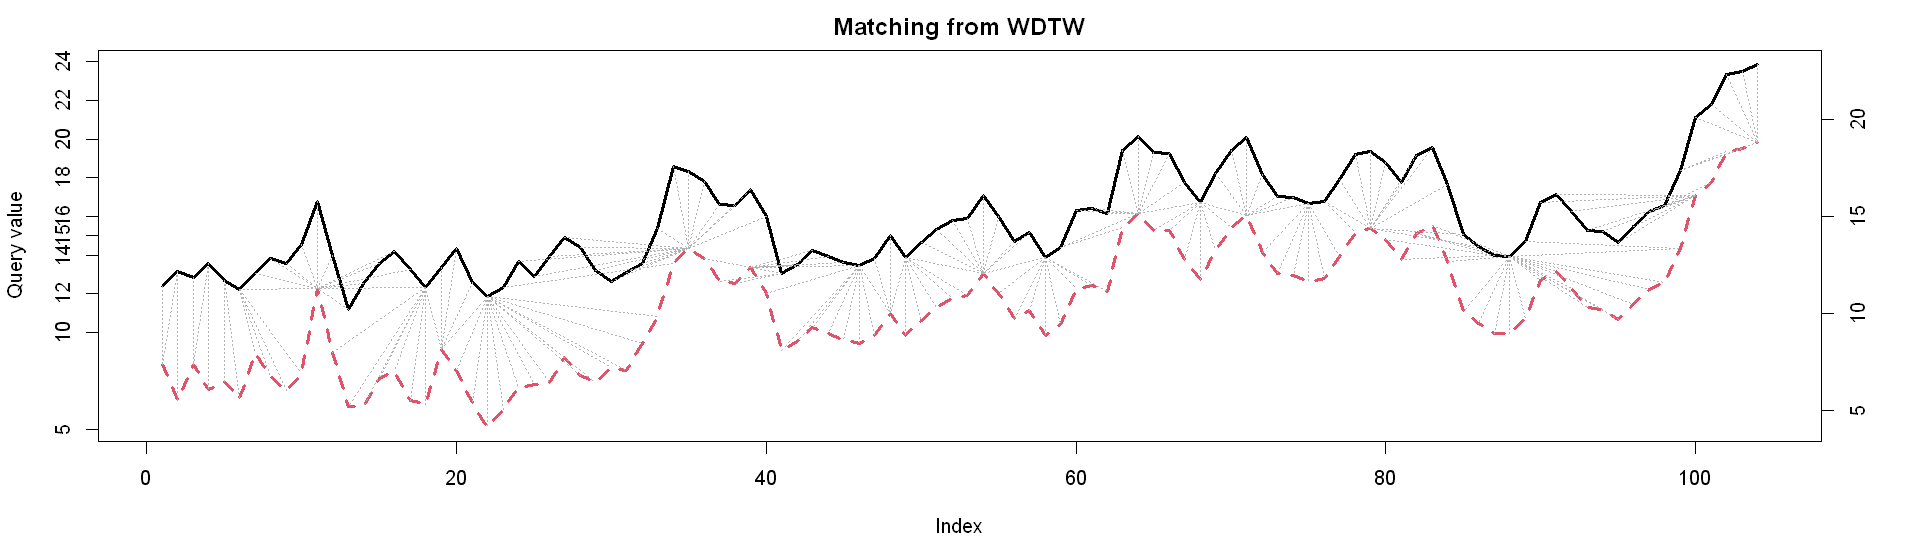

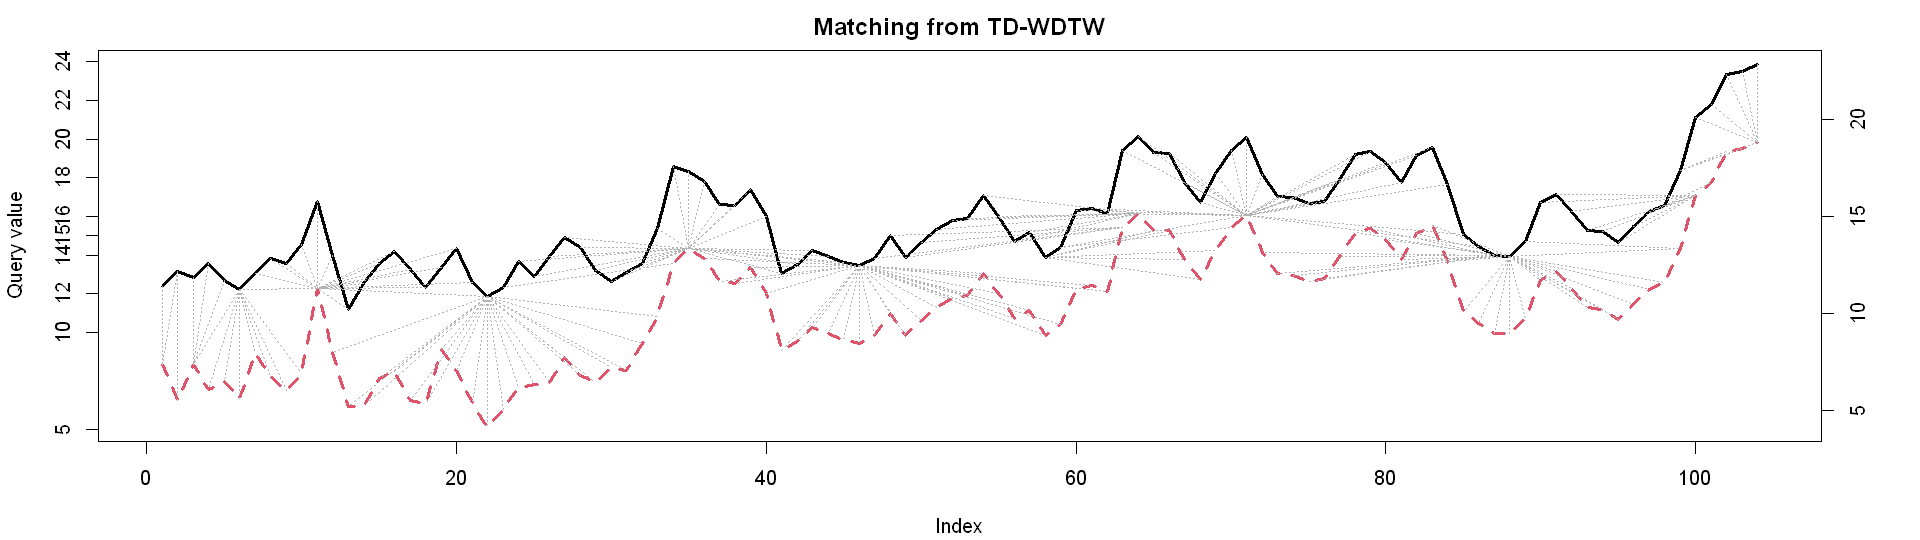

In [15]:
# DTW package
options(repr.plot.width = 16, repr.plot.height = 5)
plot(pair_1_dtw, type = "two", off = 1, lwd = 3, main = paste("Matching from", dtw_methods[1]))

# dpfast DTW
plot_matching(seq_ref, seq_q1, pair_1, methods = dtw_methods[2])

# dpfast WDTW
plot_matching(seq_ref, seq_q1, pair_1_wdtw, methods = dtw_methods[3])

# dpfast TDWDTW
plot_matching(seq_ref, seq_q1, pair_1_tdwdtw, methods = dtw_methods[4])

#### 4.2 Plot Toy Example

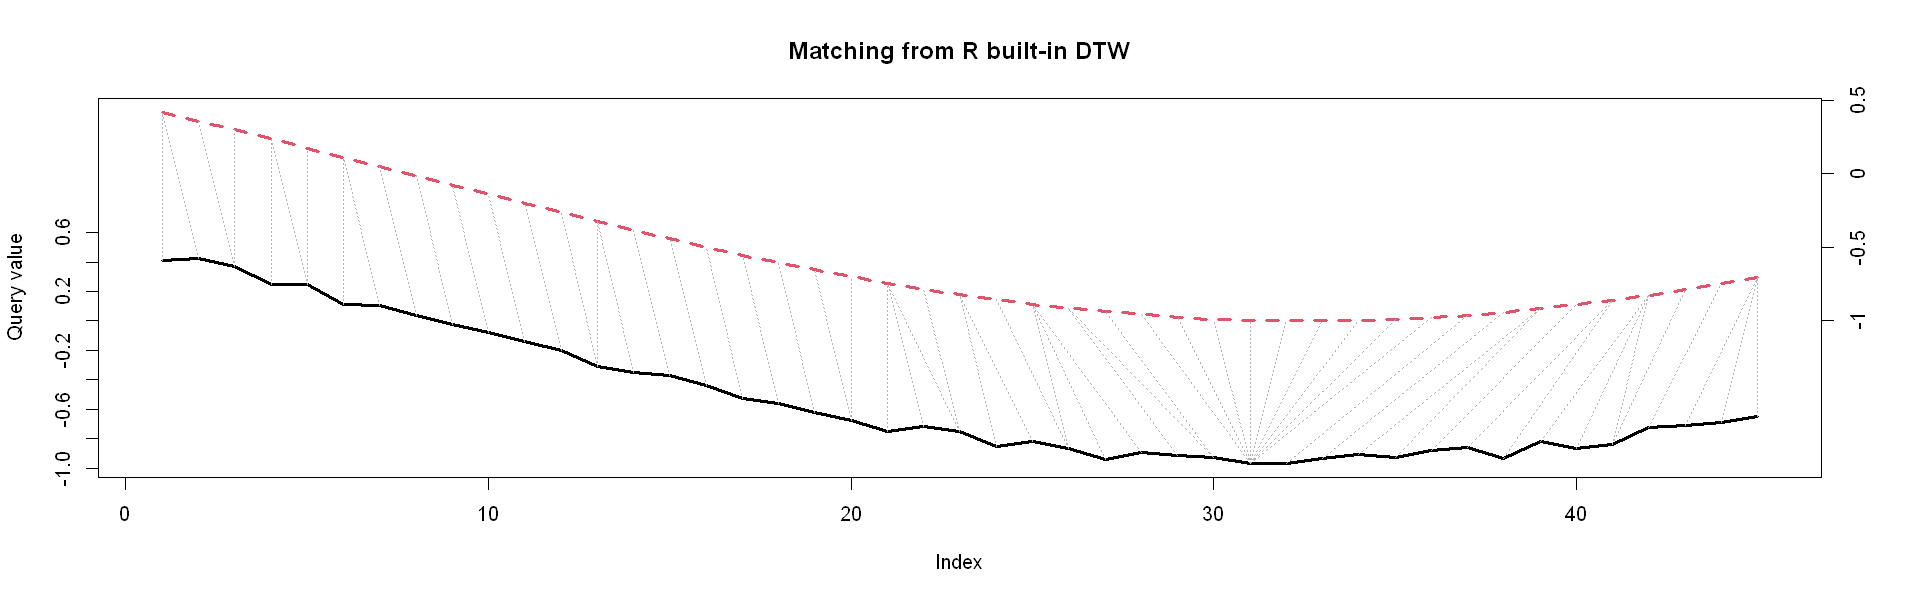

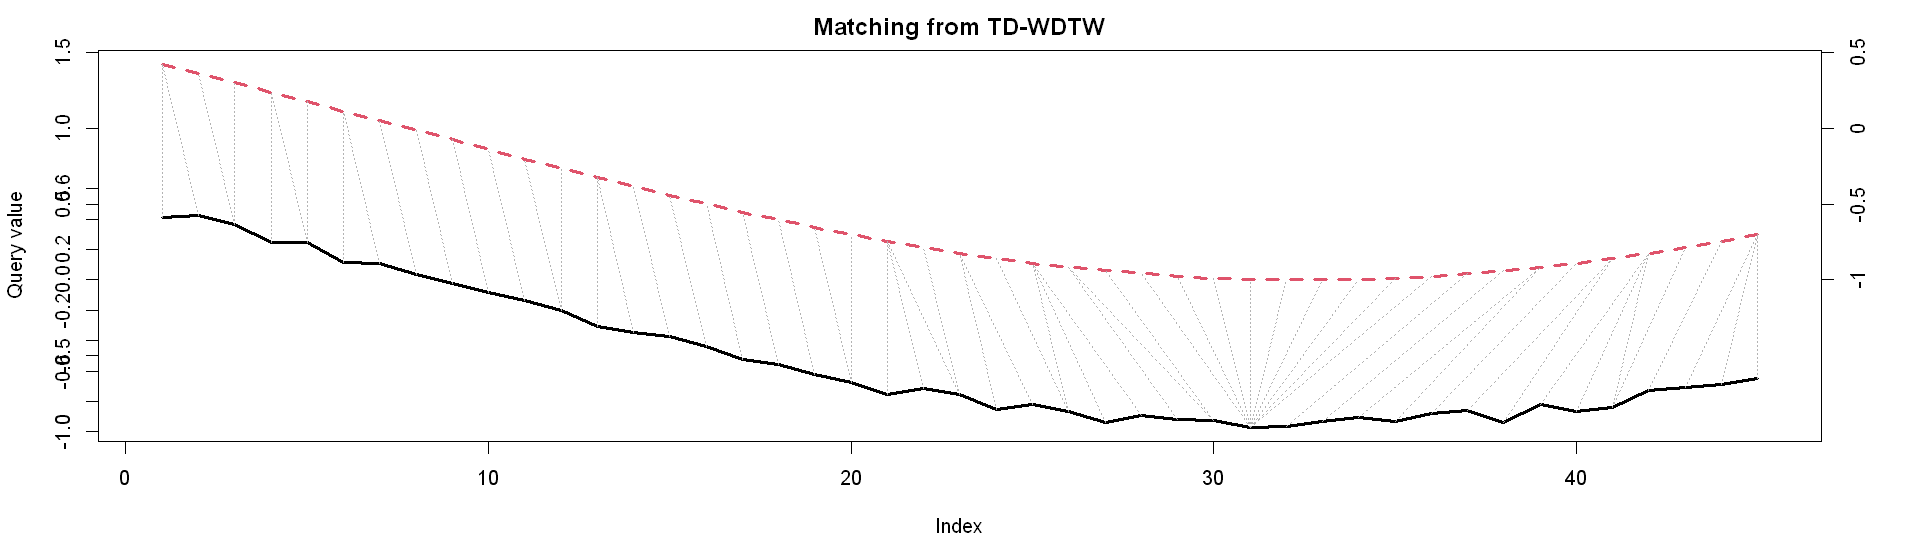

In [16]:
options(repr.plot.width = 16, repr.plot.height = 5)
plot(pair_test_dtw, type = "two", off = 1, lwd = 3, main = "Matching from R built-in DTW")
plot_matching(query[44:88], reference[19:63], pair_test_tdwdtw, methods = "TD-WDTW")

### 5. Window Type

+ ``sakoechiba``: A band around main diagonal

+ ``slantedband``: A band around slanted diagonal

+ ``itakura``: So-called Itakura parallelogram

The choice of whether to use a window size or not in DTW depends on the specific requirements and characteristics of the data.

Without a window size, the DTW algorithm will consider all possible alignments between the two time series, allowing for non-linear mappings. This can be beneficial if significant variations are expected in the temporal dynamics or if the two time series have different lengths. Without a window size, the DTW distance will reflect the overall similarity between the two time series, regardless of any local misalignments.

On the other hand, using a window size can introduce constraints on the alignment, which can be useful when we have prior knowledge about the expected temporal relationship between the time series. By limiting the maximum allowed difference in indices between matched elements, the DTW algorithm focuses on finding a more locally consistent alignment. This can be beneficial when we want to emphasize local patterns or when we want to reduce the computational complexity of the algorithm.

To determine which approach is better, following factors are considered:

- Data characteristics: Examine the nature of the time series data. Are there expected local patterns or global trends? Are the time series of similar lengths? Understanding the characteristics of the data can help decide whether a window size is appropriate or if the algorithm should have the flexibility to align any part of the time series.

- Prior knowledge: If we have prior knowledge or domain expertise about the expected temporal relationship between the time series, it can guide the decision. For example, if we know that certain parts of the time series should align closely, using a window size that allows for small temporal shifts can be beneficial.

- Computational complexity: Using a window size can reduce the computational complexity of the DTW algorithm, as it limits the search space for optimal alignment. If we have large time series data or if computational efficiency is a concern, using a window size might be preferable.

Ultimately, the choice between using a window size or not in DTW depends on the specific requirements and characteristics of your data, as well as desired trade-offs between flexibility, local alignment, and computational complexity. It can be helpful to experiment with different approaches and evaluate their performance on specific task or application.

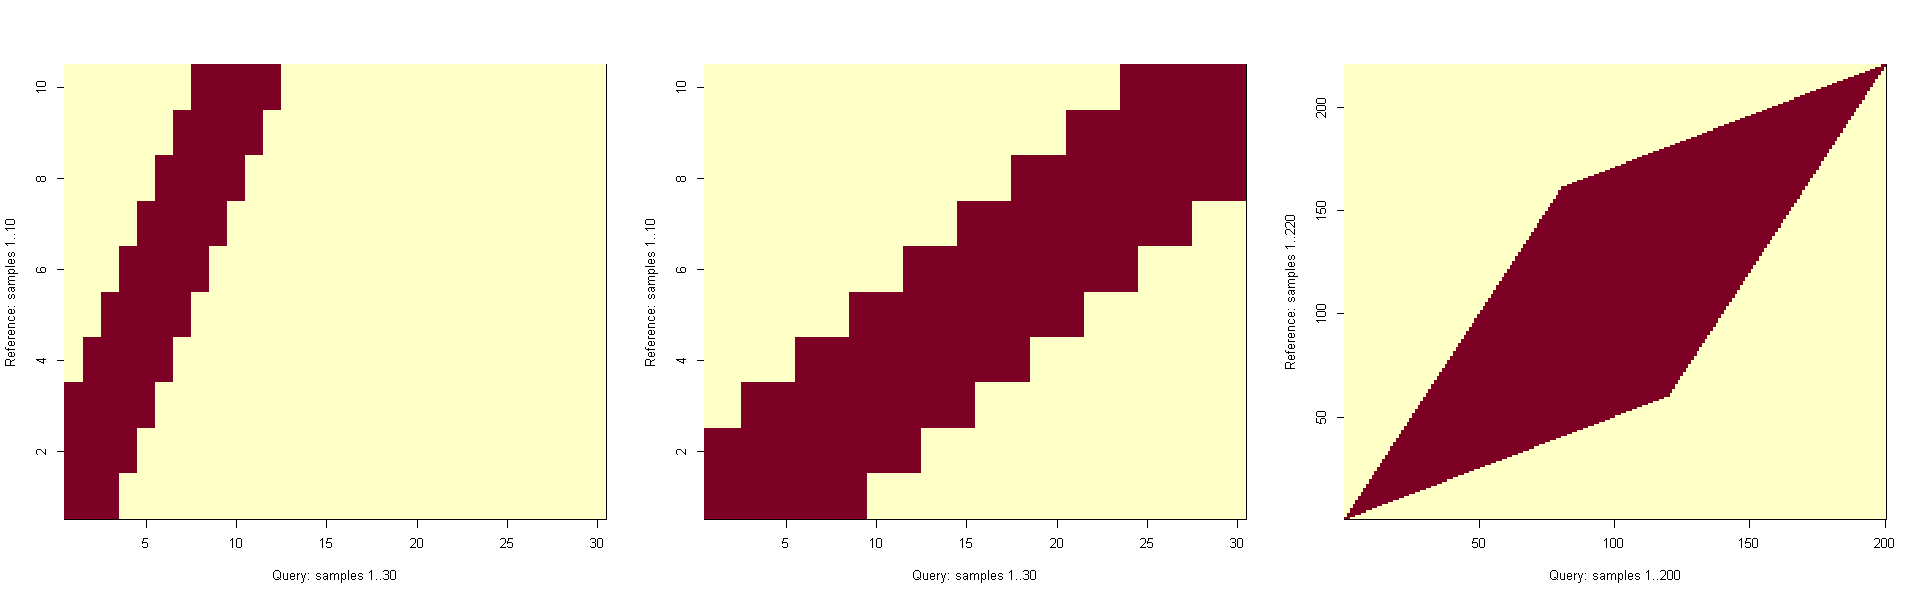

In [17]:
par(mfrow = c(1, 3))
options(repr.plot.width = 16, repr.plot.height = 5)
dtwWindow.plot(sakoeChibaWindow, window.size = 2, ref = 10, query = 30)
dtwWindow.plot(slantedBandWindow, window.size = 2, ref = 10, query = 30)
dtwWindow.plot(itakuraWindow)

#### 5.1 Pre-defined Window in DTW Package

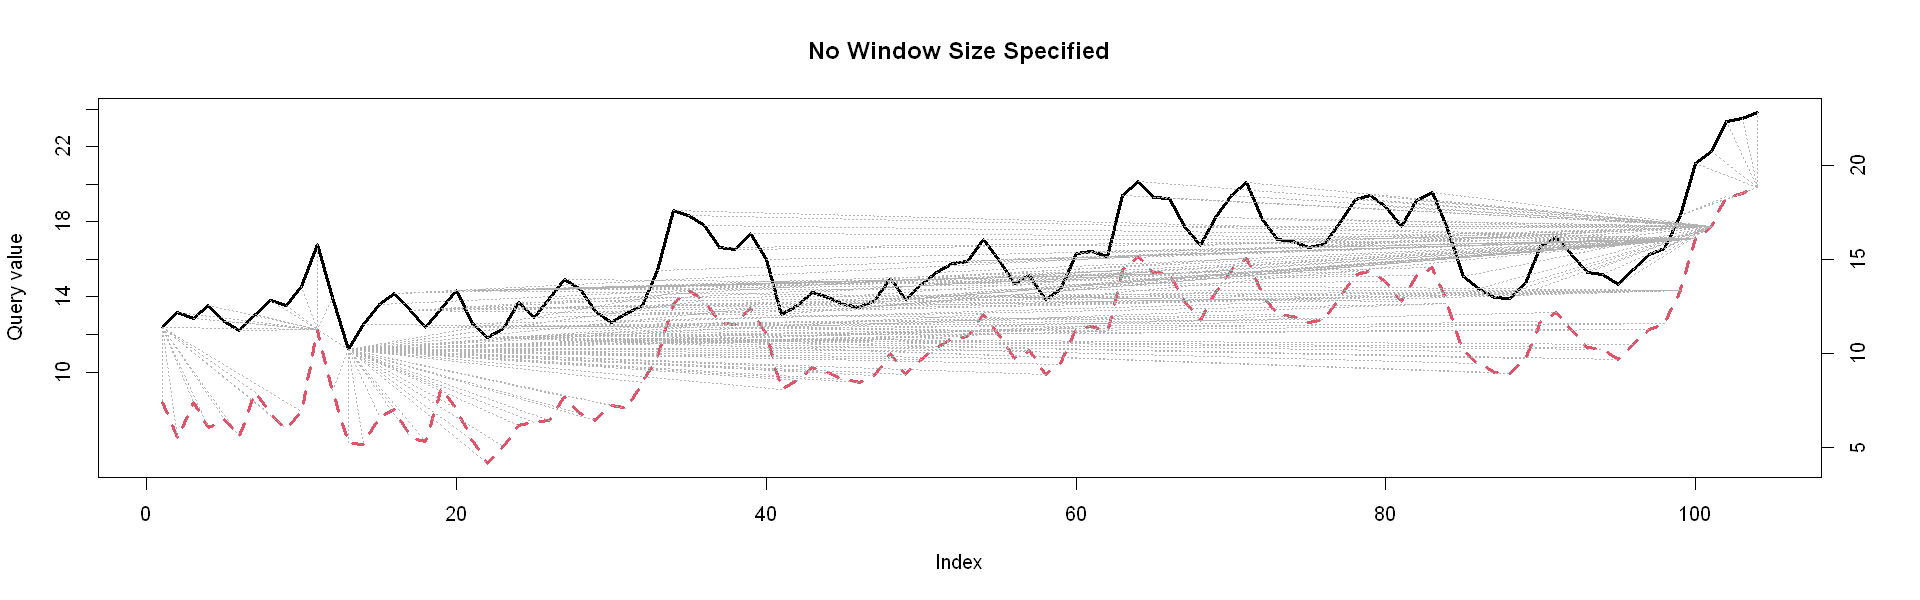

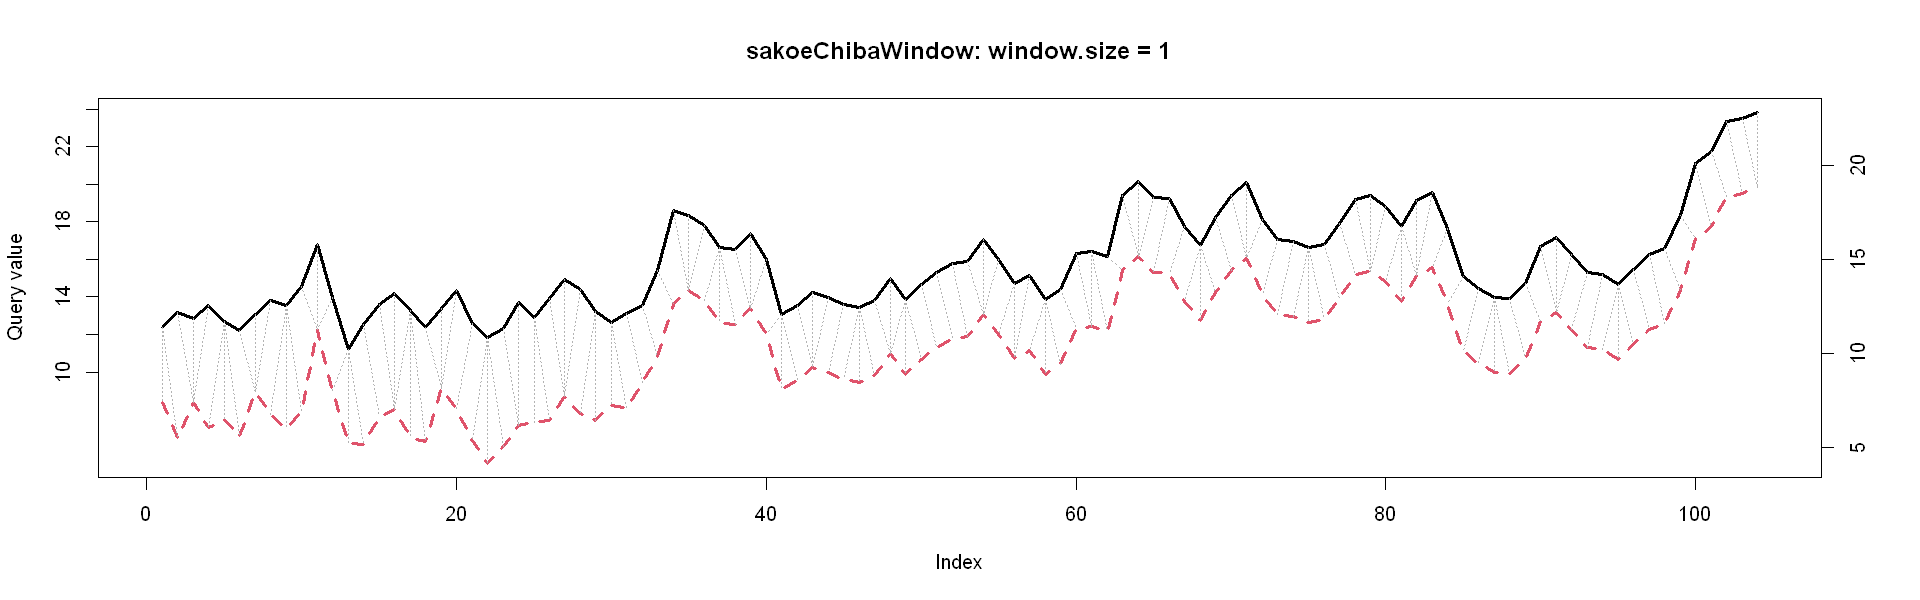

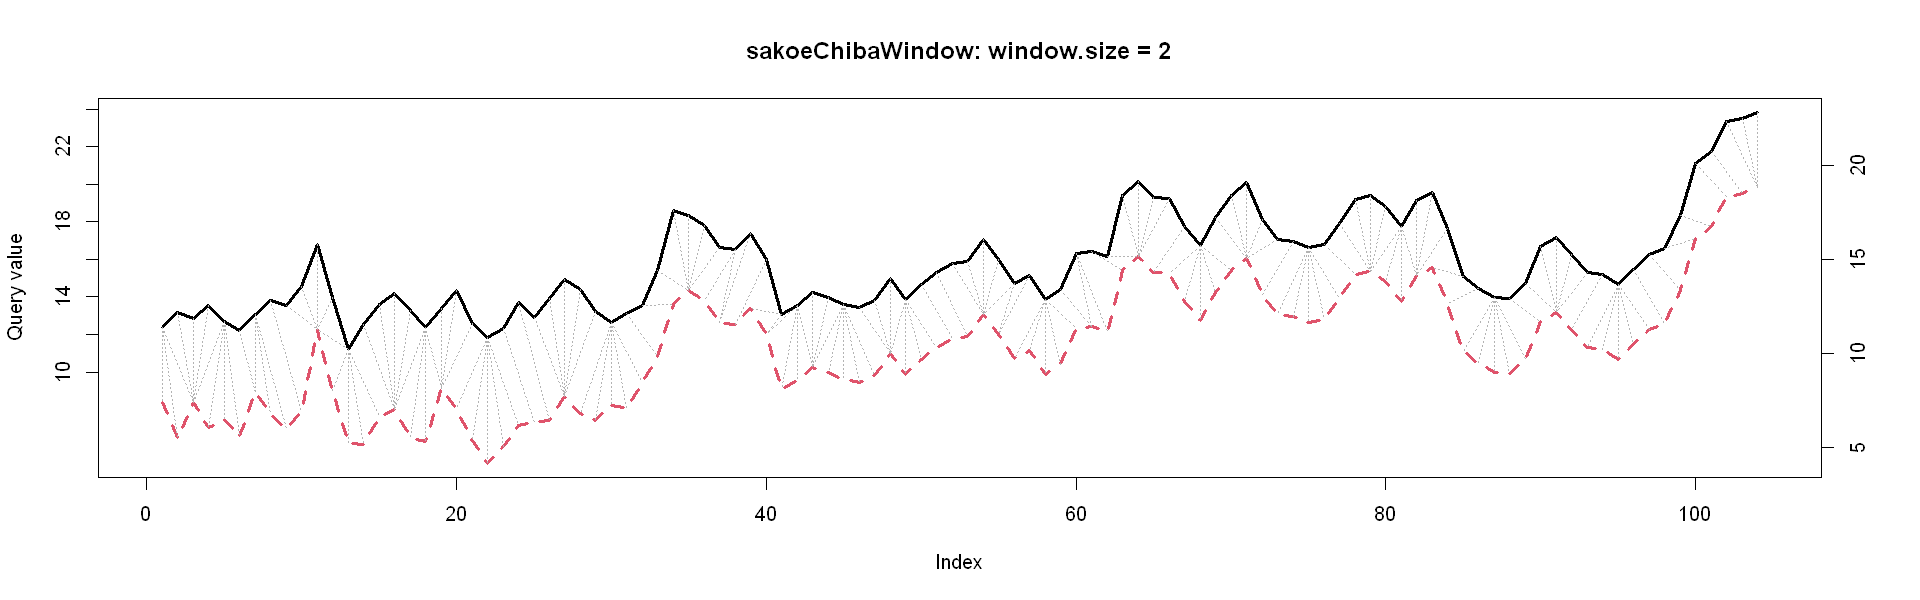

In [18]:
pair_1_ws1_dtw <- dtw(x = seq_ref, y = seq_q1, keep = TRUE, window.type = sakoeChibaWindow, window.size = 1)
pair_1_ws2_dtw <- dtw(x = seq_ref, y = seq_q1, keep = TRUE,  window.type = sakoeChibaWindow, window.size = 2)

options(repr.plot.width = 16, repr.plot.height = 5)
plot(pair_1_dtw, type = "two", off = 1, lwd = 3, main = "No Window Size Specified")
plot(pair_1_ws1_dtw, type = "two", off = 1, lwd = 3, main = "sakoeChibaWindow: window.size = 1")
plot(pair_1_ws2_dtw, type = "two", off = 1, lwd = 3, main = "sakoeChibaWindow: window.size = 2")

In [19]:
distance <- c(pair_1_dtw$distance, pair_1_ws1_dtw$distance, pair_1_ws2_dtw$distance)
normalized_distance <- c(pair_1_dtw$normalizedDistance, pair_1_ws1_dtw$normalizedDistance, pair_1_ws2_dtw$normalizedDistance)
dist_comparison <- data.frame(matrix(NA, nrow = 3, ncol = 3))
colnames(dist_comparison) <- c("window.size", "distance", "normalized.distance")
dist_comparison[, 1] <- c("No window", "1", "2")
dist_comparison[, 2]<- distance
dist_comparison[, 3] <- normalized_distance
dist_comparison

window.size,distance,normalized.distance
<chr>,<dbl>,<dbl>
No window,389.6142,1.873145
1,978.6783,4.705184
2,873.7159,4.200557


#### 5.2 Pre-defined Window in dpcore: ``sakoeChibaWindow``

algorithm,distance (no window size),distance (window.size=1),distance (window.size=2)
<chr>,<dbl>,<dbl>,<dbl>
R built-in DTW,389.614201,978.678271,873.715927
dpfast DTW,389.614201,978.678271,873.715927
WDTW,4.694959,5.741238,5.370269
TD-WDTW,28.759093,43.529030,39.011424


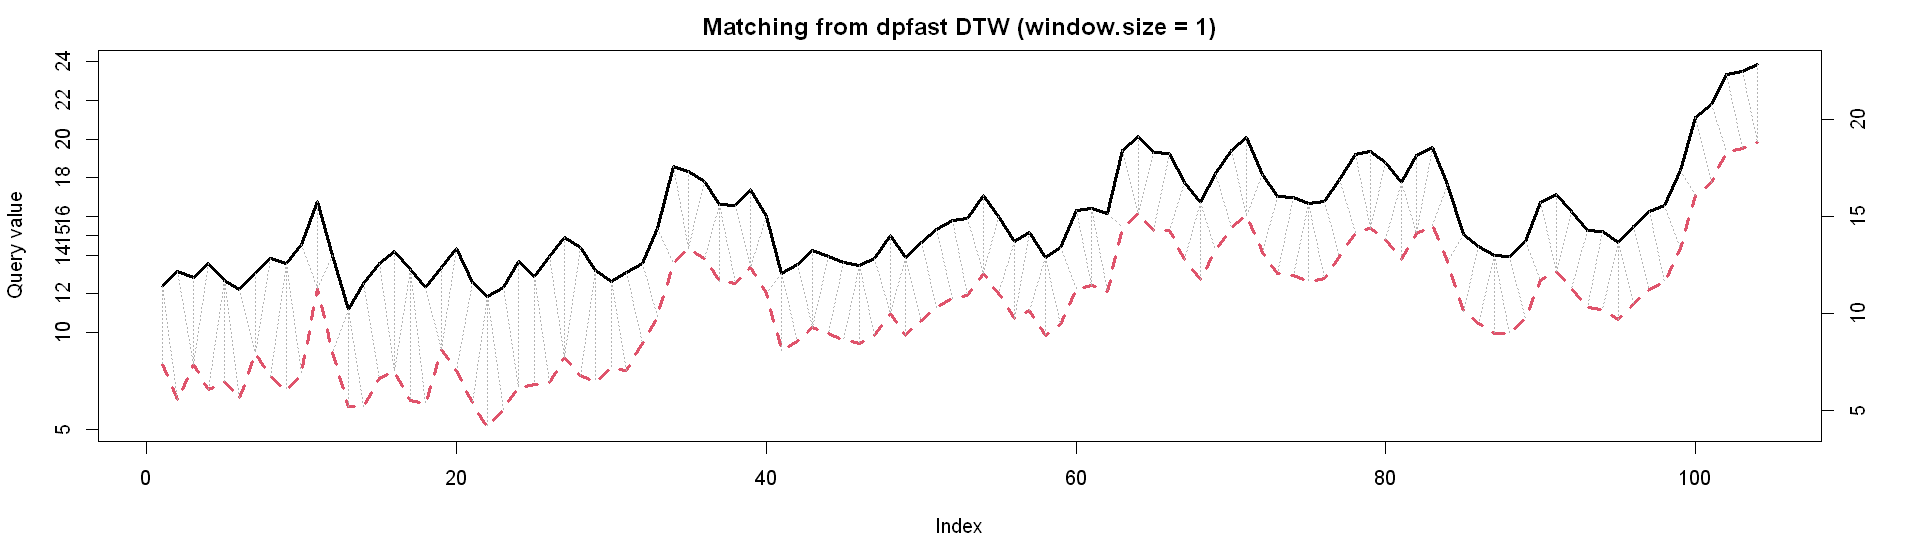

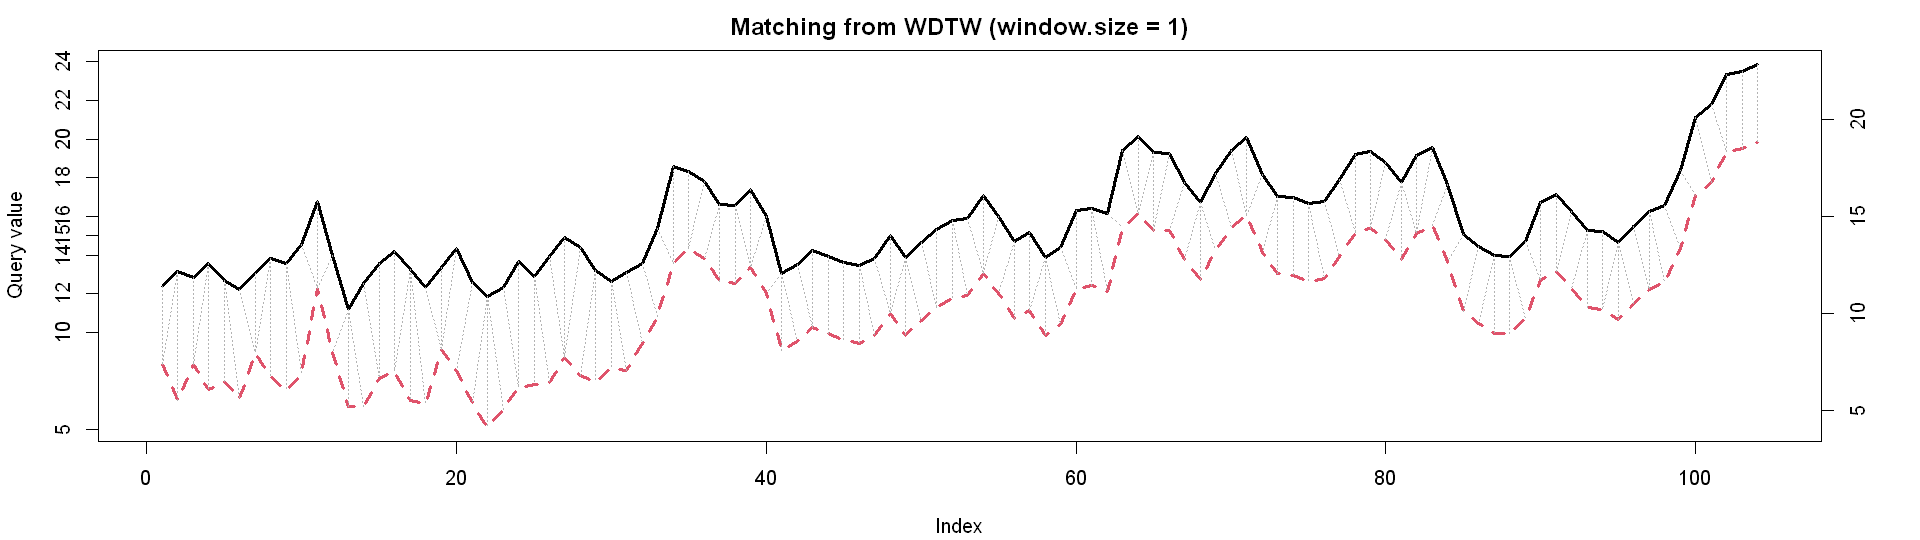

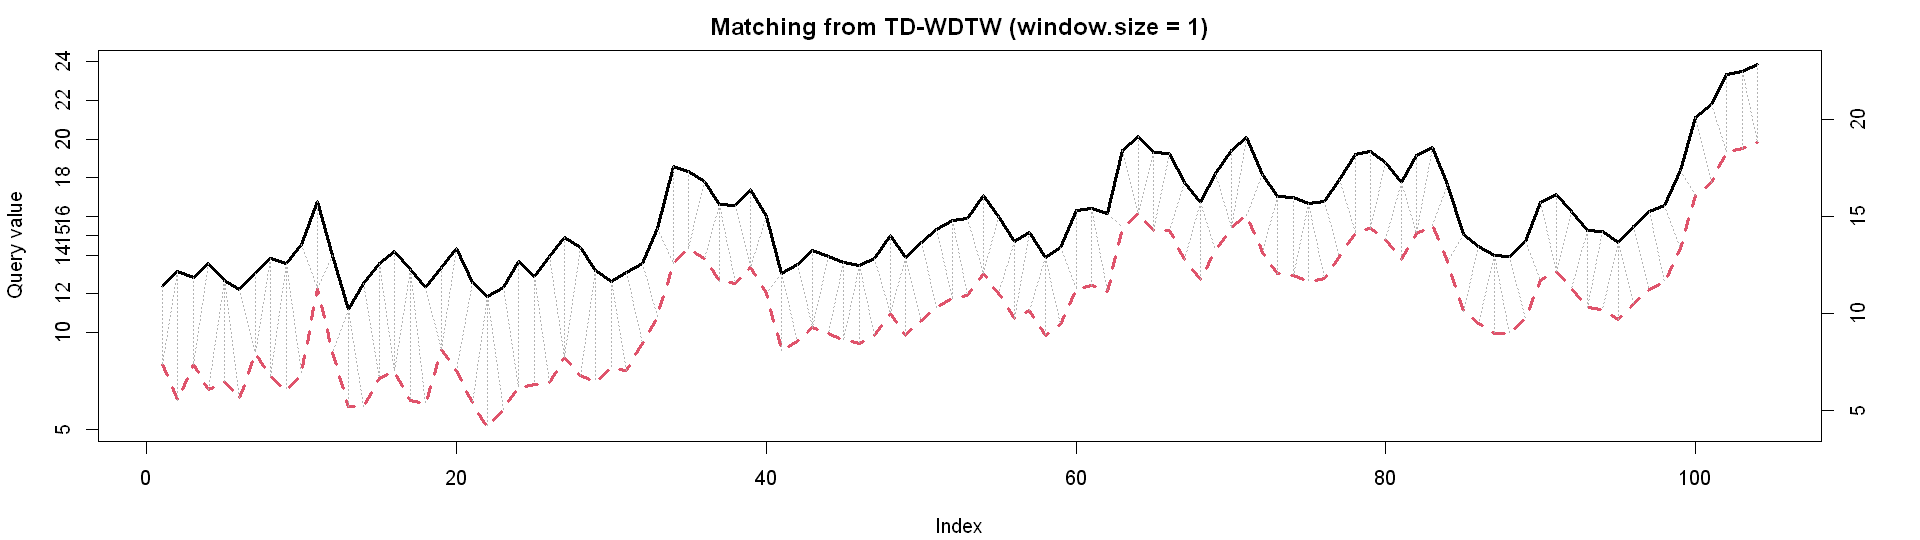

In [20]:
# Add window size = 1
pair_1_ws1 <- dpfast(M_1, C = steppattern, window_size = 1) # DTW from dpfast
pair_1_ws1_wdtw <- dpfast(M_1_wdtw, C = steppattern, window_size = 1) # WDTW
pair_1_ws1_tdwdtw <- dpfast(M_1_tdwdtw, C = steppattern, window_size = 1) # TD-WDTW

# Add window size = 2
pair_1_ws2 <- dpfast(M_1, C = steppattern, window_size = 2) # DTW from dpfast
pair_1_ws2_wdtw <- dpfast(M_1_wdtw, C = steppattern, window_size = 2) # WDTW
pair_1_ws2_tdwdtw <- dpfast(M_1_tdwdtw, C = steppattern, window_size = 2) # TD-WDTW

# Compare the difference
distance_ws0 <- c(pair_1_dtw$distance, sum(pair_1$sc), sum(pair_1_wdtw$sc), sum(pair_1_tdwdtw$sc))
distance_ws1 <- c(pair_1_ws1_dtw$distance, sum(pair_1_ws1$sc), sum(pair_1_ws1_wdtw$sc), sum(pair_1_ws1_tdwdtw$sc))
distance_ws2 <- c(pair_1_ws2_dtw$distance, sum(pair_1_ws2$sc), sum(pair_1_ws2_wdtw$sc), sum(pair_1_ws2_tdwdtw$sc))
dist_comparison <- data.frame(matrix(NA, nrow = 4, ncol = 4))
colnames(dist_comparison) <- c("algorithm", "distance (no window size)", "distance (window.size=1)", "distance (window.size=2)")
dist_comparison[, 1] <- dtw_methods
dist_comparison[, 2] <- distance_ws0
dist_comparison[, 3] <- distance_ws1
dist_comparison[, 4] <- distance_ws2
dist_comparison

# Plot matching results of window size = 1
plot_matching(seq_ref, seq_q1, pair_1_ws1, methods = "dpfast DTW (window.size = 1)")
plot_matching(seq_ref, seq_q1, pair_1_ws1_wdtw, methods = "WDTW (window.size = 1)")
plot_matching(seq_ref, seq_q1, pair_1_ws1_tdwdtw, methods = "TD-WDTW (window.size = 1)")

#### 5.3 Define Window Function

In [21]:
window_fcn <- function(M, window_size) {
    
    n_col <- ncol(M)
    n_row <- nrow(M)
    
    id_matrix <- matrix(0, nrow = n_row, ncol = n_col)
    for (j in 1:n_col) {
        i <- n_row - j + 1
        i_list <- c((i-window_size):(i+window_size))
        i_sel <- i_list[(i_list > 0) & (i_list <= n_row)]
        id_matrix[i_sel, j] <- 1
    }
    M_ws <- id_matrix * M
    M_ws[M_ws == 0] <- 999999999999999999999999999 # tricky to find a number represent Inf # max(M_ws)*2 # Inf #

    return(M_ws)
    
}

In [22]:
# DTW from dpfast
M_ws1 <- window_fcn(M_1, window_size = 1)
M_ws2 <- window_fcn(M_1, window_size = 2)
pair_1_ws1 <- dpfast(M_ws1, C = steppattern)
pair_1_ws2 <- dpfast(M_ws2, C = steppattern)

# WDTW
M_ws1_wdtw <- window_fcn(M_1_wdtw, window_size = 1)
M_ws2_wdtw <- window_fcn(M_1_wdtw, window_size = 2)
pair_1_ws1_wdtw <- dpfast(M_ws1_wdtw, C = steppattern)
pair_1_ws2_wdtw <- dpfast(M_ws2_wdtw, C = steppattern)

# TD-WDTW
M_ws1_tdwdtw <- window_fcn(M_1_tdwdtw, window_size = 1)
M_ws2_tdwdtw <- window_fcn(M_1_tdwdtw, window_size = 2)
pair_1_ws1_tdwdtw <- dpfast(M_ws1_tdwdtw, C = steppattern)
pair_1_ws2_tdwdtw <- dpfast(M_ws2_tdwdtw, C = steppattern)

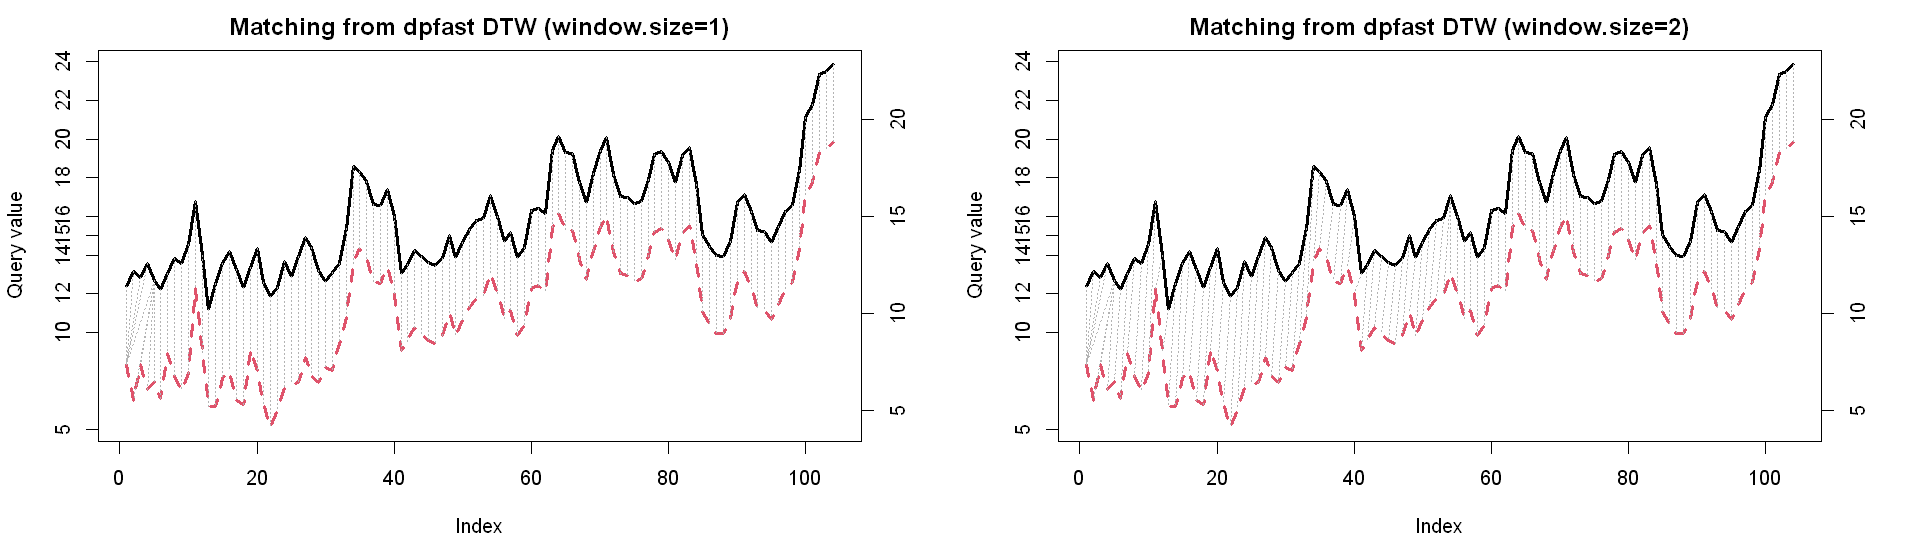

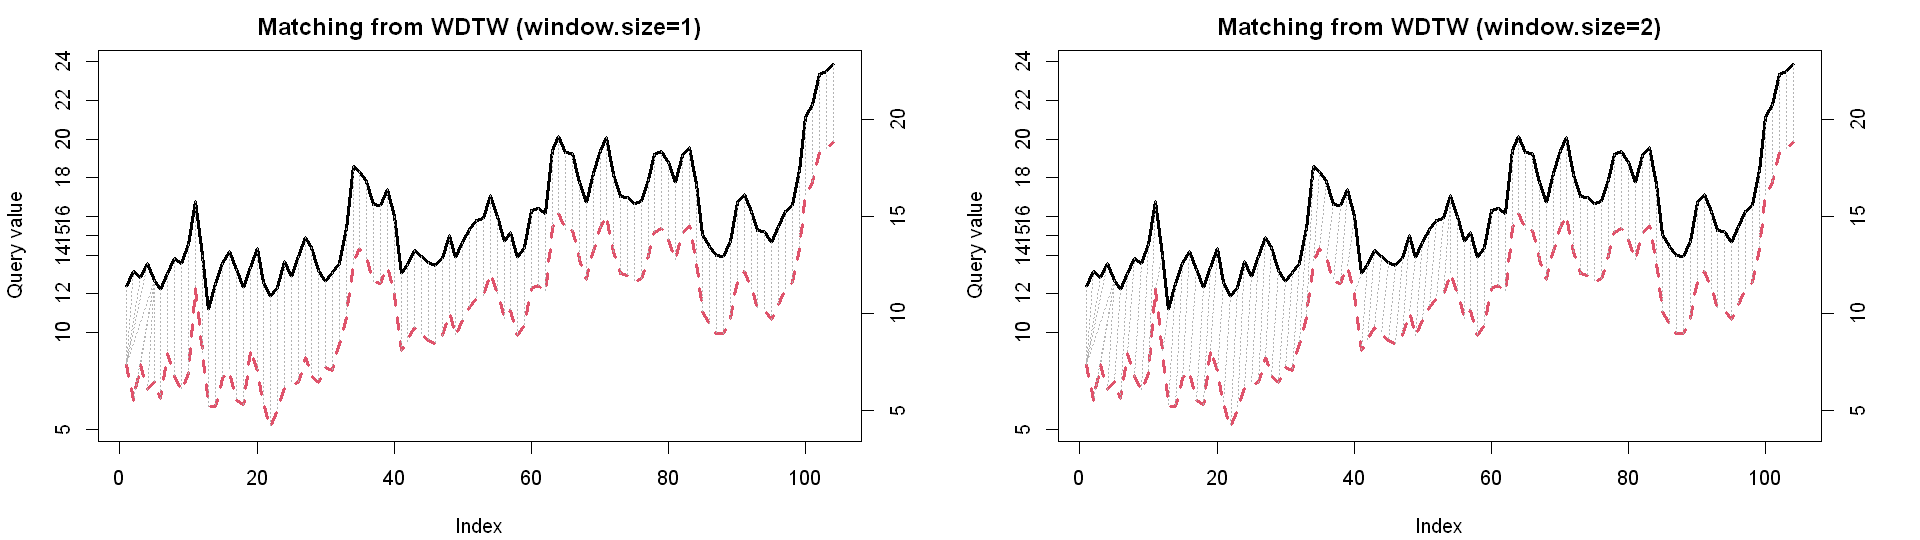

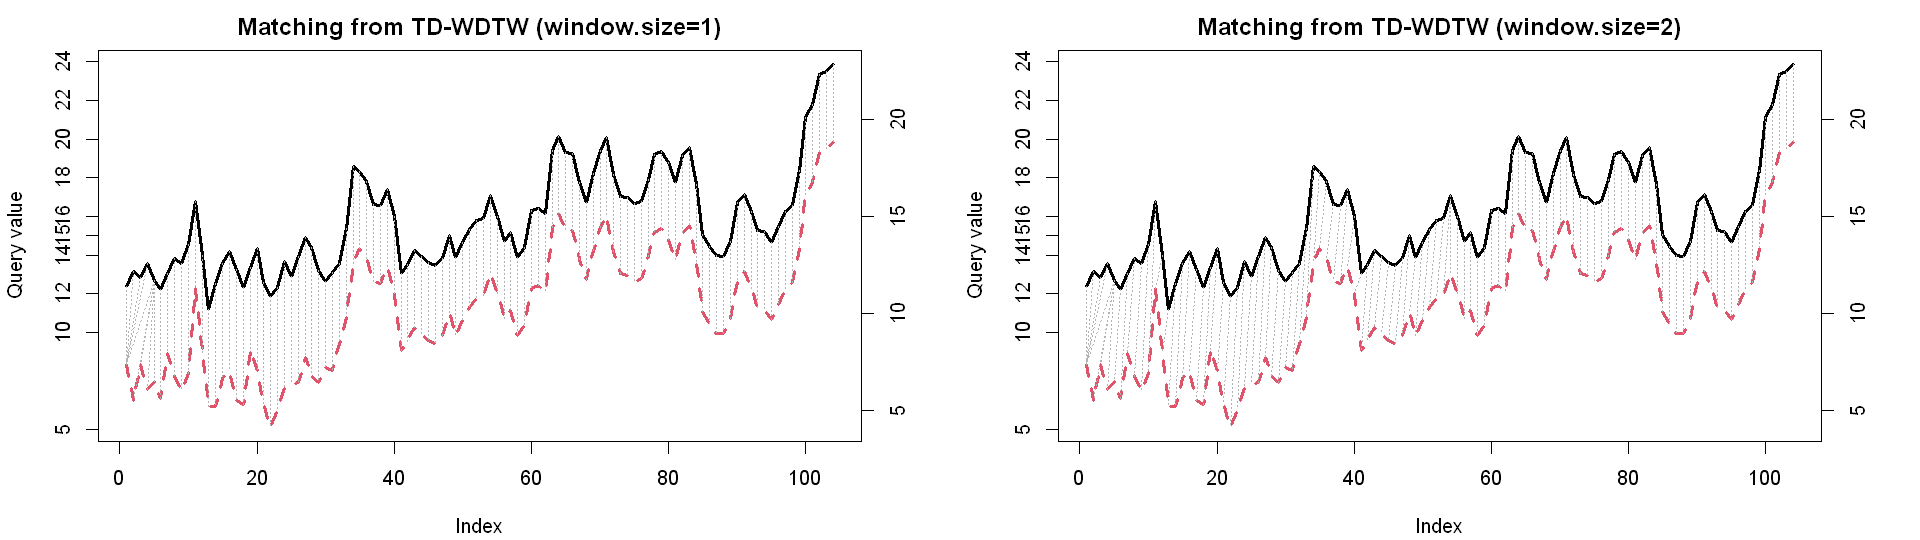

In [23]:
par(mfrow = c(1, 2))
plot_matching(seq_ref, seq_q1, pair_1_ws1, methods = "dpfast DTW (window.size=1)")
plot_matching(seq_ref, seq_q1, pair_1_ws2, methods = "dpfast DTW (window.size=2)")
plot_matching(seq_ref, seq_q1, pair_1_ws1_wdtw, methods = "WDTW (window.size=1)")
plot_matching(seq_ref, seq_q1, pair_1_ws2_wdtw, methods = "WDTW (window.size=2)")
plot_matching(seq_ref, seq_q1, pair_1_ws1_tdwdtw, methods = "TD-WDTW (window.size=1)")
plot_matching(seq_ref, seq_q1, pair_1_ws2_tdwdtw, methods = "TD-WDTW (window.size=2)")

#### 5.4 Path Comparison with Window Size Specified
- Compare the paths across different DTW algorithms with window size = 1
- Compare the paths across different DTW algorithms with window size = 2
- Compare the paths across varying window size

__Conclusion:__ 
- No difference across different DTW algorithms
- Differeces exist across varying window size

In [24]:
# Compare the paths across different window type with window size = 1
path_d1 <- sum(pair_1_ws1$p != pair_1_ws1_wdtw$p) + sum(pair_1_ws1$q != pair_1_ws1_wdtw$q) # DTW from dpfast vs. WDTW with window size = 1
path_d2 <- sum(pair_1_ws1$p != pair_1_ws1_tdwdtw$p) + sum(pair_1_ws1$q != pair_1_ws1_tdwdtw$q) # DTW from dpfast vs. TD-WDTW with window size = 1
path_d3 <- sum(pair_1_ws1_wdtw$p != pair_1_ws1_tdwdtw$p) + sum(pair_1_ws1_wdtw$q != pair_1_ws1_tdwdtw$q) # DTW from dpfast vs. TD-WDTW with window size = 1
path_comparison <- data.frame(matrix(NA, nrow = 3, ncol = 3))
colnames(path_comparison) <- c("pairs", "window.size", "count.path.diff")
path_comparison[, 1] <- c("DTW vs. WDTW", "DTW vs. TDT-WDTW", "WDTW vs. TD-WDTW")
path_comparison[, 2] <- rep(1, 3)
path_comparison[, 3] <- c(path_d1, path_d2, path_d3)
path_comparison

pairs,window.size,count.path.diff
<chr>,<dbl>,<int>
DTW vs. WDTW,1,0
DTW vs. TDT-WDTW,1,0
WDTW vs. TD-WDTW,1,0


In [25]:
# Compare the paths across different window type with window size = 2
path_d1 <- sum(pair_1_ws2$p != pair_1_ws2_wdtw$p) + sum(pair_1_ws2$q != pair_1_ws2_wdtw$q) # DTW from dpfast vs. WDTW with window size = 1
path_d2 <- sum(pair_1_ws2$p != pair_1_ws2_tdwdtw$p) + sum(pair_1_ws2$q != pair_1_ws2_tdwdtw$q) # DTW from dpfast vs. TD-WDTW with window size = 1
path_d3 <- sum(pair_1_ws2_wdtw$p != pair_1_ws2_tdwdtw$p) + sum(pair_1_ws2_wdtw$q != pair_1_ws2_tdwdtw$q) # DTW from dpfast vs. TD-WDTW with window size = 1
path_comparison <- data.frame(matrix(NA, nrow = 3, ncol = 3))
colnames(path_comparison) <- c("pairs", "window.size", "count.path.diff")
path_comparison[, 1] <- c("DTW vs. WDTW", "DTW vs. TDT-WDTW", "WDTW vs. TD-WDTW")
path_comparison[, 2] <- rep(2, 3)
path_comparison[, 3] <- c(path_d1, path_d2, path_d3)
path_comparison


pairs,window.size,count.path.diff
<chr>,<dbl>,<int>
DTW vs. WDTW,2,0
DTW vs. TDT-WDTW,2,0
WDTW vs. TD-WDTW,2,0


In [26]:
# Compare the paths across varying window size
path_d1 <- sum(pair_1_ws1$p != pair_1_ws2$p) + sum(pair_1_ws1$q != pair_1_ws2_wdtw$q) # DTW from dpfast vs. WDTW with window size = 1
path_d2 <- sum(pair_1_ws1_wdtw$p != pair_1_ws2_wdtw$p) + sum(pair_1_ws1_wdtw$q != pair_1_ws2_wdtw$q) # DTW from dpfast vs. TD-WDTW with window size = 1
path_d3 <- sum(pair_1_ws1_tdwdtw$p != pair_1_ws2_tdwdtw$p) + sum(pair_1_ws1_wdtw$q != pair_1_ws2_tdwdtw$q) # DTW from dpfast vs. TD-WDTW with window size = 1
path_comparison <- data.frame(matrix(NA, nrow = 3, ncol = 2))
colnames(path_comparison) <- c("algorithm", "count.path.diff")
path_comparison[, 1] <- c("DTW", "WDTW", "TD-WDTW")
path_comparison[, 2] <- c(path_d1, path_d2, path_d3)
path_comparison

algorithm,count.path.diff
<chr>,<int>
DTW,49
WDTW,49
TD-WDTW,49


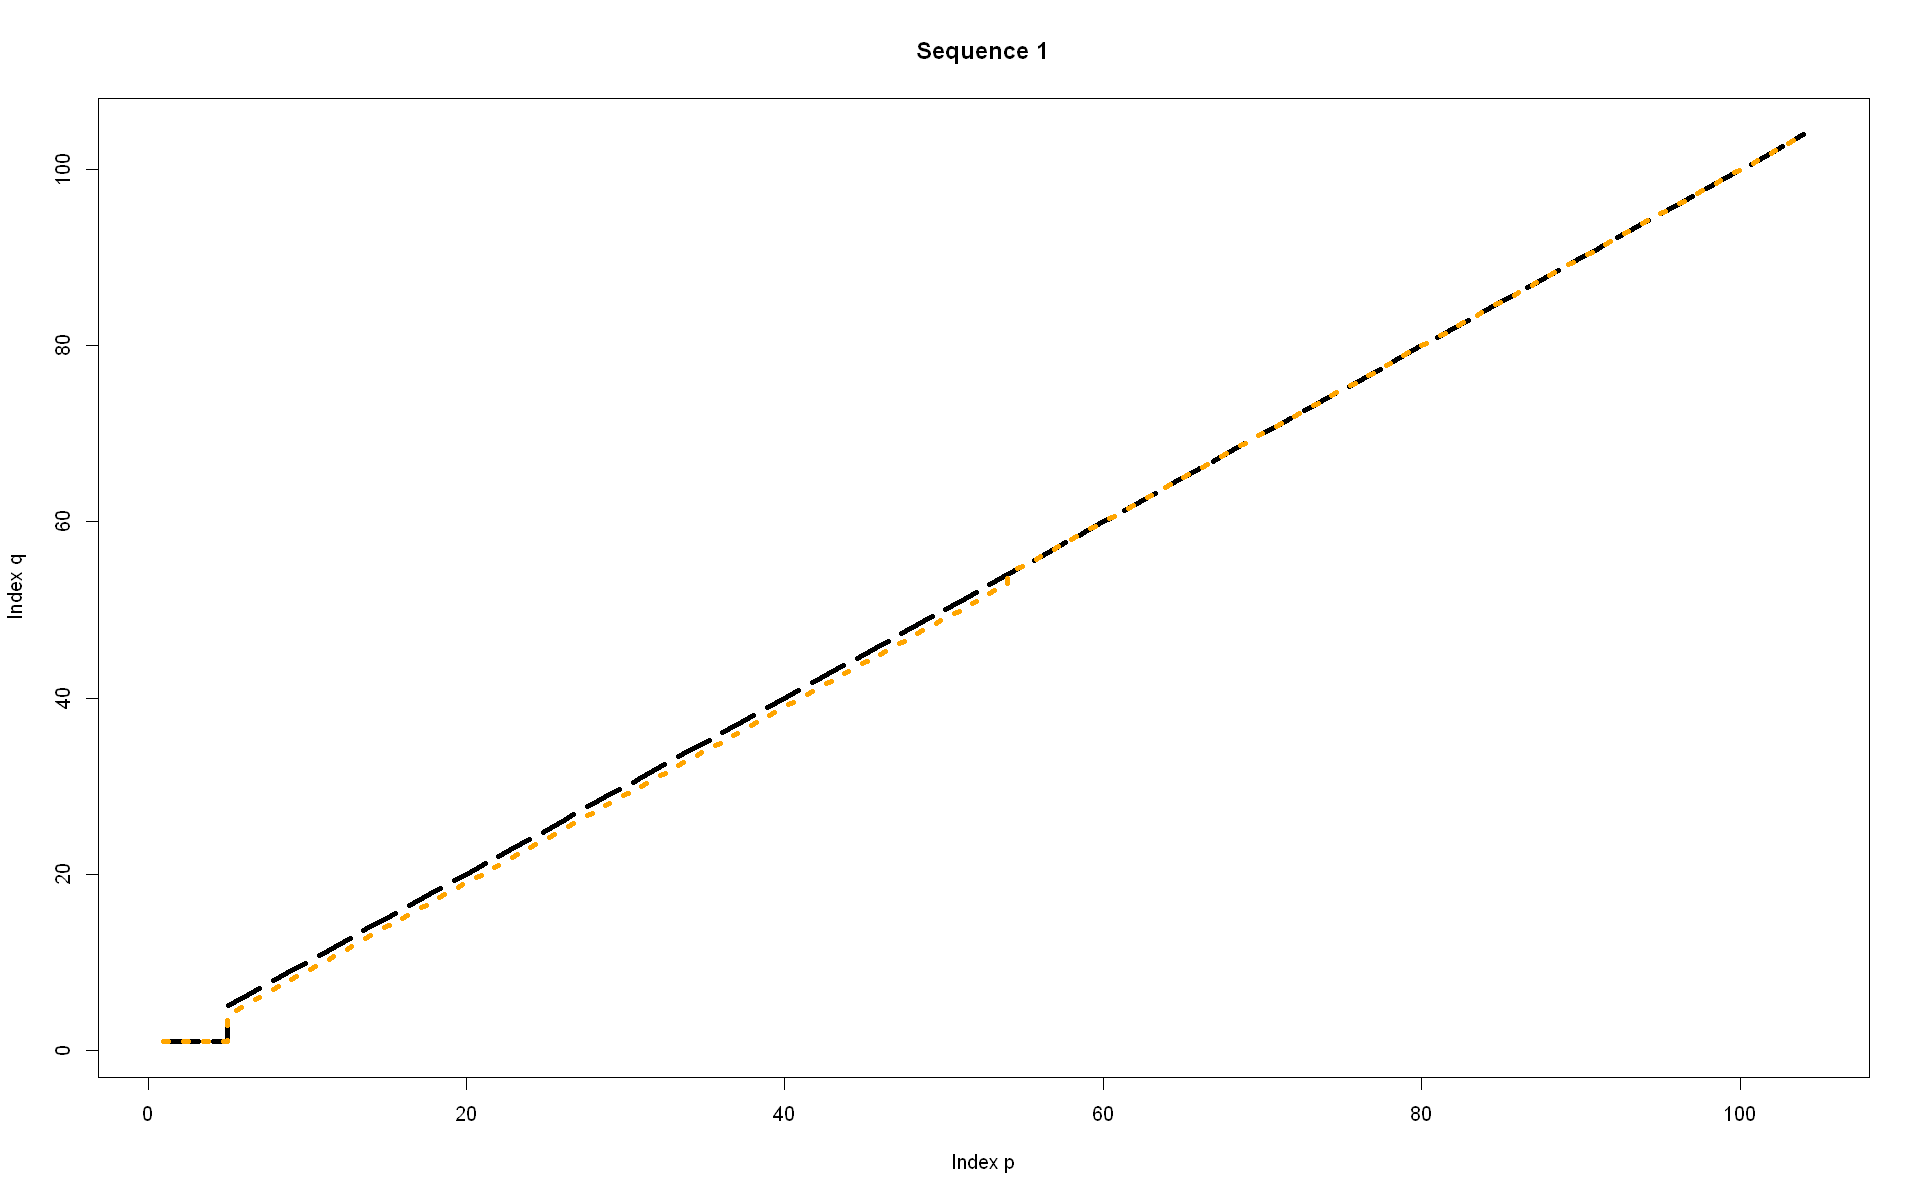

In [27]:
options(repr.plot.width = 16, repr.plot.height = 10)

plot(pair_1_ws1$p, pair_1_ws1$q, type = "l", lty = "longdash", lwd = 4,
     xlab = "Index p", ylab = "Index q", main = "Sequence 1")
lines(pair_1_ws2$p, pair_1_ws2$q,col = "orange", lty = "dotted", lwd = 4)